# RQ1 — ¿Difiere el salario anual (en escala log) entre modalidades de trabajo?

## Objetivo del análisis
Para responder **RQ1** comparamos la variable objetivo transformada:

$$
\text{log\_salary}=\log\left(1+\text{ConvertedCompYearly}\right)
$$


entre las 3 categorías de `RemoteWork`:
- **Remote**
- **Hybrid**
- **In-person**

La transformación logarítmica se usa porque el salario suele tener **colas largas y outliers**, y el log ayuda a:
- estabilizar la varianza,
- reducir influencia de valores extremos,
- acercar la distribución a la normalidad (aprox.), facilitando métodos paramétricos.

---

## Por qué ANOVA es apropiado aquí
Queremos comparar la **media** de una variable numérica (`log_salary`) entre **más de dos grupos** (3 modalidades).  
El procedimiento estándar para esto es un **ANOVA de una vía (one-way ANOVA)**.

### Hipótesis
- **H0:** las medias de `log_salary` son iguales en las 3 modalidades  
  $$
  \mu_{Remote}=\mu_{Hybrid}=\mu_{In-person}
  $$
- **H1:** al menos una media difiere.

### Supuestos del ANOVA clásico
1. **Independencia**: cada respuesta corresponde a un encuestado distinto (se asume por el diseño de la encuesta; ademas es posible filtrar por `ResponseId` si es necesario).
2. **Normalidad aproximada de residuos**: no es necesario que `log_salary` sea perfectamente normal; lo importante es que los **residuos** del modelo lo sean aproximadamente. La transformación log ayuda.
3. **Homoscedasticidad** (varianzas similares por grupo): puede fallar en encuestas grandes/heterogéneas.

**Decisión metodológica:**  
- Ejecutamos **ANOVA clásico** como análisis base (común y fácilmente interpretable).
- Dado que la homoscedasticidad puede no cumplirse, **confirmamos con Welch ANOVA**, que es **robusto a varianzas desiguales**.  
Si ambos coinciden, la conclusión es más sólida.

---





In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df= pd.read_csv("../data/processed/df_final_v1.csv")
d = df.dropna(subset=["log_salary", "RemoteWork"]).copy()



,sum_sq,df,F,PR(>F)
C(RemoteWork),884.175795,2.0,228.977542,3.280390e-99
Residual,45224.814646,23424.0,NaN,NaN


## Preparación del dataset (población efectiva)
Como el salario tiene missingness, el análisis salarial se restringe a la subpoblación con:
- `log_salary` no nulo  
- `RemoteWork` no nulo

Esto garantiza que la comparación use únicamente participantes con información suficiente.

---

## Paso 1 — Descriptivos por grupo
Antes del contraste, se reportan **n**, **media**, **desv. estándar** y **mediana** por modalidad para:
- describir el patrón,
- contextualizar magnitud,
- anticipar posibles diferencias de dispersión.

**Resultados descriptivos (log_salary):**
- Hybrid: n=9899, media=10.8817, sd=1.2000, mediana=11.1064  
- In-person: n=3937, media=10.3539, sd=1.5120, mediana=10.7052  
- Remote: n=9591, media=10.8641, sd=1.5137, mediana=11.2253  

**Patrón inicial:**  
$$
\text{Hybrid} \approx \text{Remote} > \text{In-person}
$$

---


In [7]:
d.groupby("RemoteWork")["log_salary"].agg(["count","mean","std","median"])

,count,mean,std,median
RemoteWork,,,,
"Hybrid (some remote, some in-person)",9899,10.881707,1.200008,11.106355
In-person,3937,10.353943,1.512012,10.705198
Remote,9591,10.864146,1.513688,11.225257


## Paso 2 — ANOVA de una vía (modelo base)

Para evaluar si la **media** de `log_salary` cambia según la modalidad de trabajo, ajustamos un modelo lineal con `RemoteWork` como **factor** (variable categórica):

$$
\text{log\_salary} = \mu + \alpha_{g} + \varepsilon,\quad 
g\in\{\text{Remote, Hybrid, In-person}\}
$$

$$
\mu \text{ es la media global, } \alpha_g \text{ es el efecto del grupo } g, \text{ y } \varepsilon \text{ es el error aleatorio.}
$$


El ANOVA contrasta:

- **H0:** todos los efectos de grupo son cero (equivalente a que **todas las medias son iguales**):

$$
\alpha_{\text{Remote}}=\alpha_{\text{Hybrid}}=\alpha_{\text{In-person}}=0
$$

- **H1:** al menos uno de los efectos de grupo es distinto de cero (equivalente a que **al menos una media difiere**):

$$
\exists\, g:\ \alpha_g \neq 0
$$

El estadístico **F** se construye como la razón:

$$
F=\frac{\text{variación explicada por diferencias entre grupos}}{\text{variación residual dentro de los grupos}}
$$

Intuitivamente: si las medias de los grupos están más separadas entre sí que lo que “se dispersan” los datos dentro de cada grupo, **F** será grande.




In [10]:
# ANOVA: log_salary ~ grupo
model = smf.ols("log_salary ~ C(RemoteWork)", data=d).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(RemoteWork),884.175795,2.0,228.977542,3.280390e-99
Residual,45224.814646,23424.0,NaN,NaN


**Resultado ANOVA (one-way, `log_salary ~ C(RemoteWork)`):**

La descomposición de la variabilidad mostró que una parte de la variación total de `log_salary` se explica por la modalidad de trabajo (`RemoteWork`):

- Suma de cuadrados entre grupos (RemoteWork): **SS = 884.176**, **df = 2**
- Suma de cuadrados residual (dentro de grupos): **SS = 45224.815**, **df = 23424**
- Estadístico: **F(2, 23424) = 228.98**
- Significancia: **p = 3.28 × 10^-99**

**Interpretación:** el valor de **F** es muy alto y el **p-value** es extremadamente pequeño, por lo que se rechaza H0. En consecuencia, existe evidencia estadística muy fuerte de que **la media de `log_salary` no es igual en todas las modalidades**; es decir, **al menos dos modalidades presentan medias distintas**.

> Nota: en la tabla ANOVA, la fila **Residual** aparece con `NaN` en F y p porque el residual representa la variabilidad no explicada por el factor; no es un contraste adicional, sino el denominador usado para calcular el estadístico F.

**Siguiente paso:** dado que ANOVA solo indica que “hay diferencias”, se realizan **comparaciones post-hoc** (p.ej., Tukey HSD) para identificar **qué pares** de modalidades difieren.


In [11]:
import pingouin as pg
pg.welch_anova(dv="log_salary", between="RemoteWork", data=d)


,Source,ddof1,ddof2,F,p-unc,np2
0,RemoteWork,2,10297.436453,202.713616,4.482265e-87,0.019176


## Paso 3 — Robustez: Welch ANOVA (varianzas desiguales)

El ANOVA clásico asume **homoscedasticidad** (varianzas similares de `log_salary` entre modalidades). Dado que este supuesto puede no cumplirse en datos de encuesta heterogéneos, se estimó además un **Welch ANOVA**, que ajusta el contraste para ser **robusto ante varianzas desiguales** y tamaños de muestra distintos entre grupos.

**Resultado Welch (Pingouin):**
- $$F(2, 10297.44)=202.71$$
- $$p = 4.48 \times 10^{-87}$$
- Tamaño de efecto: $$\eta_p^2 = 0.0192$$


**Interpretación:** incluso sin asumir varianzas iguales, se rechaza H0 con evidencia muy fuerte. Por tanto, la conclusión de que **la media de `log_salary` difiere entre modalidades de trabajo** es **robusta**. El tamaño de efecto es **pequeño** ($\eta_p^2 \approx 0.019$), lo que sugiere que la modalidad explica aproximadamente **1.9%** de la variación observada en `log_salary`.


In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=d["log_salary"], groups=d["RemoteWork"], alpha=0.05)
print(tukey)


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
               group1                  group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------------
Hybrid (some remote, some in-person) In-person  -0.5278    0.0 -0.5891 -0.4664   True
Hybrid (some remote, some in-person)    Remote  -0.0176 0.6516 -0.0642  0.0291  False
                           In-person    Remote   0.5102    0.0  0.4486  0.5718   True
-------------------------------------------------------------------------------------


## Paso 4 — Comparaciones post-hoc (Tukey HSD): ¿qué modalidades difieren?

Dado que el ANOVA indicó diferencias globales en la media de `log_salary` entre modalidades, aplicamos **Tukey HSD** para identificar **qué pares de grupos** presentan diferencias, controlando el error familiar (**FWER = 0.05**) por comparaciones múltiples.

La tabla de Tukey reporta para cada par:
- `meandiff`: diferencia de medias (**group2 − group1**),
- `p-adj`: p-valor ajustado,
- `lower`, `upper`: intervalo de confianza (95%) para la diferencia,
- `reject`: si se rechaza H0 de igualdad de medias para ese par.

### Resultados clave e interpretación

1) **Hybrid vs In-person**
- `meandiff = -0.5278` (In-person − Hybrid)
- IC95% = [-0.5891, -0.4664]
- `reject = True` (p-ajustada ~ 0)

**Interpretación:** la media de `log_salary` en **Hybrid es mayor** que en **In-person**.  
(Como la diferencia es negativa y está definida como In-person − Hybrid, implica Hybrid > In-person).

---

2) **Hybrid vs Remote**
- `meandiff = -0.0176` (Remote − Hybrid)
- IC95% = [-0.0642, 0.0291]
- `reject = False` (p-ajustada = 0.6516)

**Interpretación:** **no hay evidencia estadística** de diferencia en la media de `log_salary` entre **Hybrid** y **Remote**. El intervalo incluye 0 y el p-ajustado es alto.

---

3) **In-person vs Remote**
- `meandiff = 0.5102` (Remote − In-person)
- IC95% = [0.4486, 0.5718]
- `reject = True` (p-ajustada ~ 0)

**Interpretación:** la media de `log_salary` en **Remote es mayor** que en **In-person**.  
La diferencia es positiva (Remote − In-person > 0) y el intervalo no incluye 0.

---

### Conclusión integrada con el ANOVA y los descriptivos

Estos resultados refinan la conclusión del ANOVA: la diferencia global entre grupos se explica principalmente porque el grupo **In-person** presenta un `log_salary` promedio **significativamente menor** que los grupos **Remote** y **Hybrid**. En cambio, **Remote y Hybrid no difieren** estadísticamente entre sí.

En términos del patrón general (coherente con las medias descriptivas):
\[
\text{Remote} \approx \text{Hybrid} > \text{In-person}
\]

> Nota metodológica: Tukey HSD asume varianzas similares entre grupos. Dado que también se ejecutó Welch ANOVA (robusto a heterocedasticidad) y el resultado fue consistente, la evidencia de que **In-person < (Remote, Hybrid)** es robusta. Para máxima coherencia con Welch, complementaremos este analisis con un post-hoc robusto, en este caso con **Games–Howell**.


In [12]:
import pingouin as pg

# d ya es el df filtrado con log_salary y RemoteWork no nulos
gh = pg.pairwise_gameshowell(dv="log_salary", between="RemoteWork", data=d)
gh.sort_values("pval")
gh


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,"Hybrid (some remote, some in-person)",In-person,10.881707,10.353943,0.527764,0.026947,19.584971,6005.193237,2.017164e-12,0.407064
1,"Hybrid (some remote, some in-person)",Remote,10.881707,10.864146,0.017561,0.019605,0.895711,18263.807752,6.430217e-01,0.012879
2,In-person,Remote,10.353943,10.864146,-0.510203,0.028628,-17.821561,7331.426989,0.000000e+00,-0.337150



## Post-hoc robusto: Games–Howell (coherente con Welch ANOVA)

Para identificar **qué pares** de modalidades difieren en `log_salary` bajo supuestos robustos (varianzas desiguales y tamaños de muestra distintos), se aplicó el post-hoc **Games–Howell**. Este método es el complemento natural de Welch ANOVA.

### Resultados e interpretación por pares

1) **Hybrid vs In-person**
- Medias: Hybrid = 10.8817, In-person = 10.3539  
- Diferencia (A − B): diff = 0.5278  
- p = 2.02e-12

**Interpretación:** `log_salary` promedio es **significativamente mayor** en **Hybrid** que en **In-person**. La magnitud de la diferencia en escala log es moderada y consistente con el patrón descriptivo.

---

2) **Hybrid vs Remote**
- Medias: Hybrid = 10.8817, Remote = 10.8641  
- Diferencia: diff = 0.0176  
- p = 0.643

**Interpretación:** no hay evidencia de diferencia estadísticamente significativa entre **Hybrid** y **Remote**. La diferencia observada es muy pequeña en magnitud y compatible con 0.

---

3) **In-person vs Remote**
- Medias: In-person = 10.3539, Remote = 10.8641  
- Diferencia: diff = -0.5102 (In-person − Remote)  
- p ≈ 0

**Interpretación:** `log_salary` promedio es **significativamente menor** en **In-person** que en **Remote**. El signo negativo indica que Remote > In-person.

---

### Conclusión integrada (consistente con ANOVA, Welch y Tukey)

Games–Howell confirma el mismo patrón observado anteriormente:
- **Remote y Hybrid presentan medias similares entre sí**
- Ambas modalidades muestran `log_salary` **mayor** que **In-person**

En forma resumida:

$$
\text{Remote} \approx \text{Hybrid} > \text{In-person}
$$

Esto refuerza que la diferencia global detectada por ANOVA/Welch se explica principalmente por el contraste entre **trabajo presencial** contra **modalidades con componente remoto**.


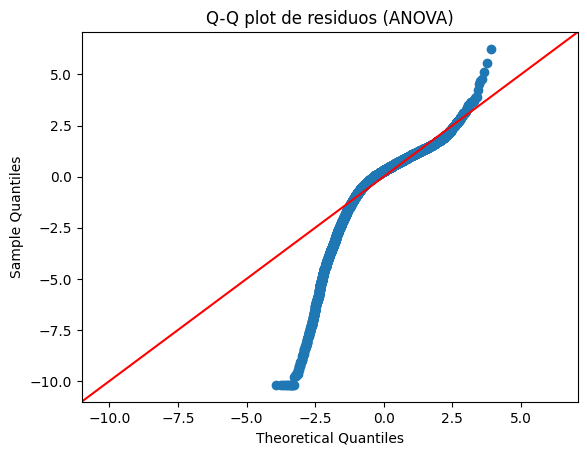

Shapiro-Wilk (muestra de residuos):
ShapiroResult(statistic=np.float64(0.8195353631320328), pvalue=np.float64(1.1578279301571444e-59))

Jarque-Bera (residuos completos):
SignificanceResult(statistic=np.float64(98730.98562582159), pvalue=np.float64(0.0))

Levene / Brown-Forsythe (center=median):
LeveneResult(statistic=np.float64(125.78333515755567), pvalue=np.float64(4.615799335666482e-55))

Levene (center=mean):
LeveneResult(statistic=np.float64(174.47391126101357), pvalue=np.float64(6.106553820457625e-76))


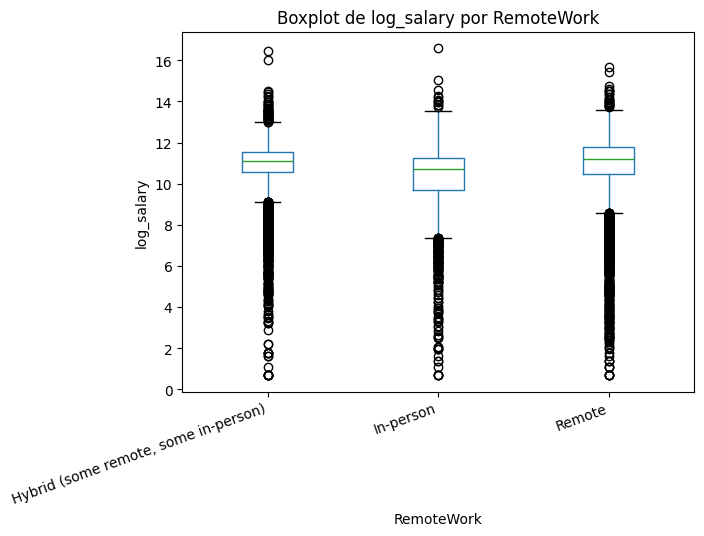

In [14]:

from scipy import stats
import matplotlib.pyplot as plt

model = smf.ols("log_salary ~ C(RemoteWork)", data=d).fit()

# Residuos y ajustados
resid = model.resid
fitted = model.fittedvalues

# A) Normalidad de residuos

# (i) Q-Q plot
sm.qqplot(resid, line="45")
plt.title("Q-Q plot de residuos (ANOVA)")
plt.show()

# (ii) Shapiro-Wilk 
# Si N>5000, tomamos una muestra aleatoria para que tenga sentido práctico
n = len(resid)
if n > 5000:
    resid_sample = resid.sample(5000, random_state=42)
else:
    resid_sample = resid

shapiro = stats.shapiro(resid_sample)
print("Shapiro-Wilk (muestra de residuos):")
print(shapiro)

# (iii) Jarque-Bera (más común con N grande)
jb = stats.jarque_bera(resid)
print("\nJarque-Bera (residuos completos):")
print(jb)

# B) Homogeneidad de varianzas por grupo

groups = [grp["log_salary"].values for _, grp in d.groupby("RemoteWork")]

# (i) Levene (center='median' ~ Brown-Forsythe; más robusto)
levene_med = stats.levene(*groups, center="median")
print("\nLevene / Brown-Forsythe (center=median):")
print(levene_med)

# (ii) Levene clásico (center='mean')
levene_mean = stats.levene(*groups, center="mean")
print("\nLevene (center=mean):")
print(levene_mean)

# (iii) Boxplot para ver dispersión por grupo (visual)
d.boxplot(column="log_salary", by="RemoteWork", grid=False)
plt.title("Boxplot de log_salary por RemoteWork")
plt.suptitle("")
plt.xlabel("RemoteWork")
plt.ylabel("log_salary")
plt.xticks(rotation=20, ha="right")
plt.show()


## Chequeo de supuestos (ANOVA)

Aunque el ANOVA es relativamente robusto con tamaños muestrales grandes, se evaluaron dos condiciones clave para interpretar el ANOVA clásico:

### 1) Normalidad aproximada de los residuos
Se inspeccionaron los residuos del modelo `log_salary ~ C(RemoteWork)` mediante:
- Un gráfico Q–Q (para evaluar desviaciones sistemáticas de la normalidad).
- Pruebas formales (Shapiro-Wilk sobre una muestra de residuos y Jarque–Bera sobre el total).

Nota importante: con N grande, las pruebas de normalidad tienden a resultar “significativas” incluso para desviaciones pequeñas. Por eso, la interpretación se apoya principalmente en el Q–Q plot y en la magnitud visual de las desviaciones.

### 2) Homogeneidad de varianzas entre grupos (homoscedasticidad)
Se evaluó si la dispersión de `log_salary` es similar entre modalidades mediante:
- Prueba de Levene con centro en la mediana (equivalente a Brown–Forsythe), que es más robusta.
- Boxplots por grupo para comparar visualmente la variabilidad.

Como la homoscedasticidad es cuestionable, se justifica el uso de métodos robustos:
- Welch ANOVA como contraste global
- Games–Howell como post-hoc


## Conclusión final para RQ1

Los análisis globales (ANOVA) y robustos (Welch), junto con las comparaciones post-hoc (Tukey y Games–Howell), proporcionan evidencia consistente de que el salario anual transformado (`log_salary`) **difiere según la modalidad de trabajo**. En particular, las modalidades con componente remoto presentan medias de `log_salary` **más altas** que la modalidad completamente presencial, mientras que **Remote y Hybrid no muestran diferencias estadísticamente significativas entre sí**.

En síntesis, el patrón observado es:

$$
\text{Remote} \approx \text{Hybrid} > \text{In-person}
$$

Aunque la diferencia es altamente significativa, el **tamaño de efecto es pequeño** ($\eta_p^2 \approx 0.019$), lo que sugiere que la modalidad de trabajo explica solo una fracción limitada de la variación en `log_salary`. Por ello, estas diferencias deben interpretarse como **asociaciones promedio** y siempre en contexto, considerando que factores estructurales (por ejemplo, país, experiencia, rol y educación) pueden influir simultáneamente en la modalidad y el salario. La evaluación de estos posibles confundidores se aborda en **RQ2**.

---

## Notas y limitaciones

- El análisis se restringe a la subpoblación con `has_salary=True` (personas que **reportaron salario**), por lo que la generalización a toda la encuesta es limitada.
- El estudio es observacional: los resultados describen **asociaciones**, no efectos causales (modalidad ≠ causa directa del salario).
- Parte de las diferencias observadas podría estar mediada o confundida por variables como `Country`, `YearsCodePro`, `DevType` y `EdLevel`; por ello, la conclusión de RQ1 se complementa con el modelo ajustado en RQ2.
